# Distribution of distances from MD simulation using GFN-FF in xTB

Import libraries

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, re
import statsmodels.api as sm

Read in the trajectory file `xtb.xyz` and input file, `md_input.inp`, find the total time (in ps) and the dump rate (in fs).

In [198]:
xtb = pd.read_csv('xtb.xyz')

In [199]:
with open('md_input.inp', 'r', encoding='utf-8') as md:
    lines = md.readlines()
    for line in lines:
        if 'time' in line:
            total_time = int(re.findall(pattern='\d+', string=line)[0])
        elif 'dump' in line:
            dump = float(re.findall(pattern='\d+\.\d+', string=line)[0])
            

Enter the locations of radicals in Avogadro (numbers of atoms).

In [200]:
o1 = 276
o2 = 323

Extract the coordinates and put them in the dataframe.

In [201]:
#reading number of atoms

for col in xtb.columns:
    n_rows = int(col)+2
    
#Creating dataframes of separate atoms

df_o1 = xtb[xtb.index % n_rows == o1]
df_o2 = xtb[xtb.index % n_rows == o2]


#Formatting strings, splitting into columns, delete the element column, setting type to float

df_o1 = df_o1['{}'.format(n_rows-2)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_o1 = df_o1.drop(columns=0).astype('float64').rename({1:'x1', 2:'y1', 3:'z1'}, axis=1).reset_index(drop=True)


df_o2 = df_o2['{}'.format(n_rows-2)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_o2 = df_o2.drop(columns=0).astype('float64').rename({1:'x2', 2:'y2', 3:'z2'}, axis=1).reset_index(drop=True)

#Combining into single dataframe
coords = pd.concat([df_o1, df_o2], axis=1)




Calculate distance and add time.

In [202]:
coords['distance'] = np.sqrt((coords['x2'] - coords['x1'])**2 + (coords['y2'] - coords['y1'])**2 + (coords['z2'] - coords['z1'])**2)/10
coords['time'] = np.arange(10, total_time*1000+10, dump)

Visualization, distance with time

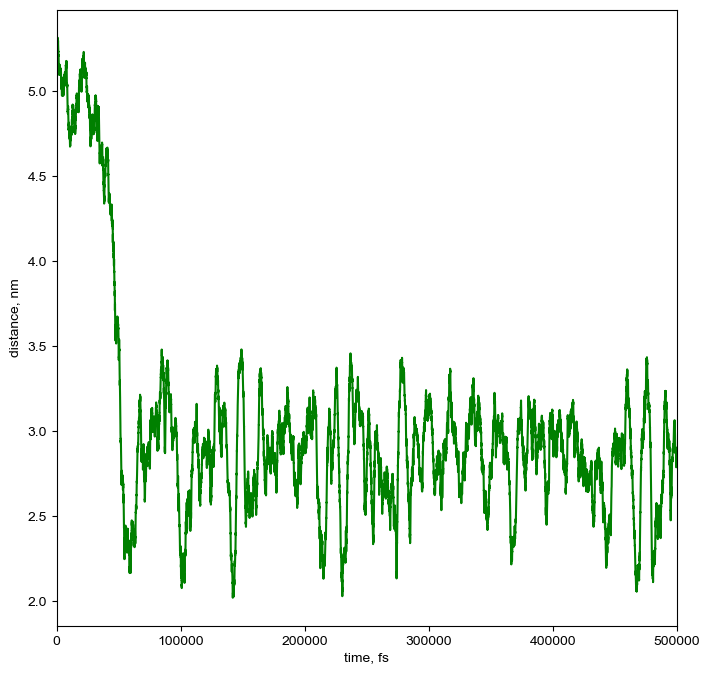

In [203]:
#sns.set_context("talk")
#sns.set_style("whitegrid", {"axes.edgecolor": "black"})
sns.lineplot(data=coords, x="time", y="distance", color='g')
plt.xlim(0, total_time*1000)
plt.ylim()

plt.xlabel('time, fs')
plt.ylabel('distance, nm')



plt.gcf().set_size_inches(8, 8)

    
# plt.savefig('dist_time.png', dpi=600)


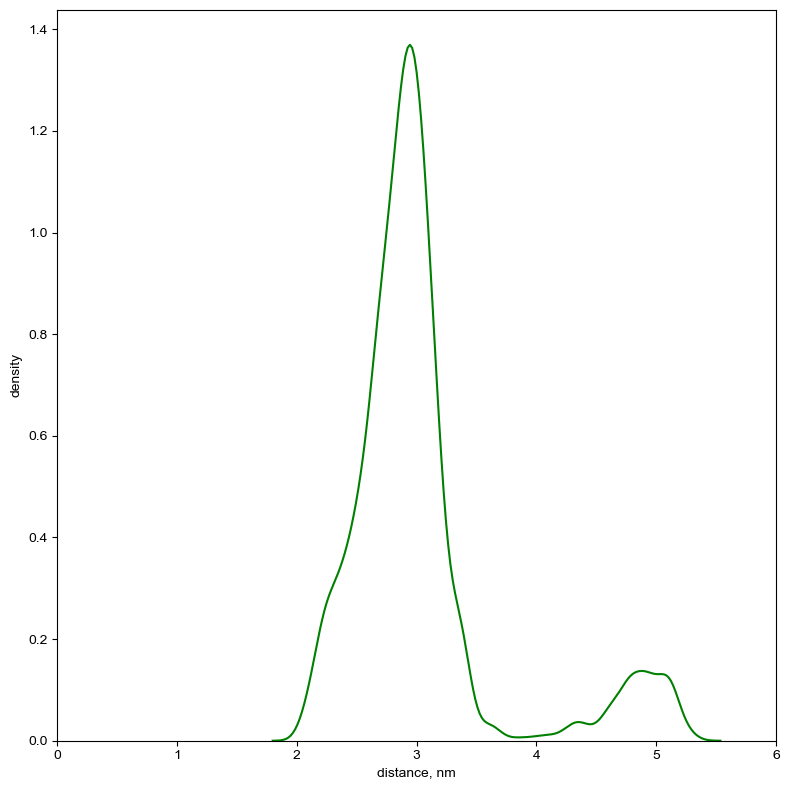

In [204]:
sns.kdeplot(data=coords, x="distance", color='g', common_norm=True)

plt.xlabel('distance, nm')
plt.ylabel('density')

plt.xlim([0,6])

plt.gcf().set_size_inches(8, 8)
plt.savefig('kde.png', dpi=600)
plt.tight_layout()
plt.show()

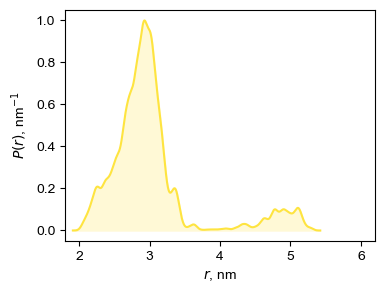

In [205]:

kde = sm.nonparametric.KDEUnivariate(coords['distance']).fit()
r, P = (kde.support, kde.density)
P = (P-np.min(P))/(np.max(P)-np.min(P))


plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.figure(figsize=(4,3))
plt.plot(r, P, color='#fee440')

plt.fill_between(r, P, color='#fff9d6')
plt.xlim(1.8,6.2)
plt.xlabel('$r$, nm')
plt.ylabel('$P(r)$, nm$^{-1}$')

plt.savefig('md_P8.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()

In [206]:
bot_lim = 2
up_lim = 4.4
indices_r = np.where((r>bot_lim)&(r<up_lim))[0]
index_P = np.where(P == P[indices_r].max())[0]
print(r[index_P])

[2.92843809]
